In [1]:
import os
import tensorflow as tf
import numpy as np

In [4]:
# import dataset from directory
DIR_PATH = os.path.join('cleaned_data', 'building_dataset_all')
IMAGE_SIZE = 244
BATCH_SIZE = 32
# =============================
# Create Image Dataset form Directory
# =============================
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'

)
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)


Found 2065 files belonging to 2 classes.
Using 1859 files for training.
Metal device set to: Apple M1 Max


2022-12-04 15:50:03.127132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 15:50:03.127259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2065 files belonging to 2 classes.
Using 206 files for validation.


2022-12-04 15:50:30.952626: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


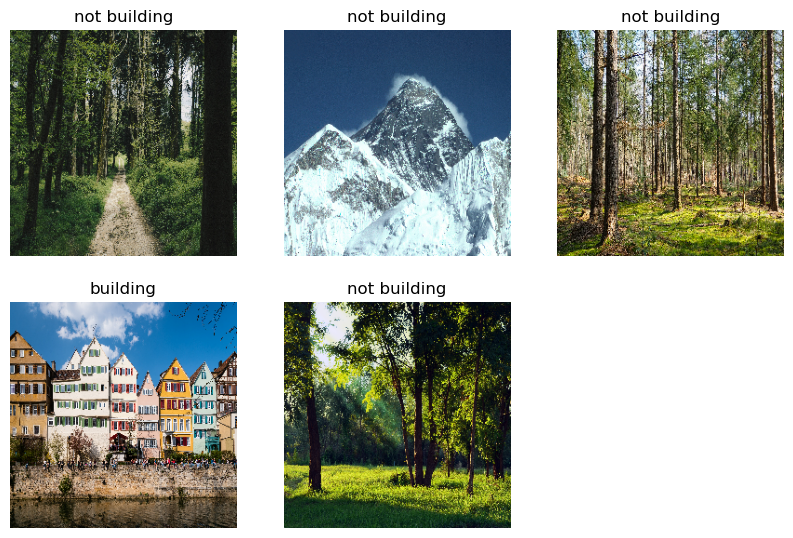

In [5]:
# Visualize data
images = None
labels = None
class_names = ds_train.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# data augmentation
with tf.device('/CPU:0'): # for Apple Silicon which does not yet support random() with GPU
    augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.4, 0.6)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0, -0.2),
                                                              width_factor=(0, -0.2)),
    ])

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

augmented_ds_train = ds_train.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

augmented_ds_train = augmented_ds_train.cache()
augmented_ds_train = augmented_ds_train.prefetch(buffer_size=10)

In [8]:
rescaling = tf.keras.Sequential([
    # rescaling
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [53]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet")

In [54]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 122, 122, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 122, 122, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [55]:
base_model.trainable = False

In [62]:
model = tf.keras.models.Sequential(
    [
        rescaling,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(2, activation='softmax')
    ]
)

In [63]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 64)                81984     
                                                                 
 dense_21 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,340,098
Trainable params: 82,114
Non-

In [69]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
history = model.fit(augmented_ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10


2022-12-04 17:42:14.766475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - ETA: 0s - loss: 2.3462e-04 - accuracy: 1.0000

2022-12-04 17:42:18.536748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 12s 171ms/step - loss: 2.3462e-04 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9951
Epoch 2/10
59/59 [==============================] - 9s 148ms/step - loss: 1.6799e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9951
Epoch 3/10
59/59 [==============================] - 9s 148ms/step - loss: 1.2964e-04 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9951
Epoch 4/10
59/59 [==============================] - 9s 147ms/step - loss: 1.0293e-04 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 0.9951
Epoch 5/10
59/59 [==============================] - 9s 148ms/step - loss: 8.1086e-05 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9951
Epoch 6/10
59/59 [==============================] - 9s 148ms/step - loss: 6.4773e-05 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 0.9951
Epoch 7/10
59/59 [==============================] - 9s 148ms/step - loss: 5.2006e-05 - accuracy: 1.0000 - val_loss: 0.0257 - val_accur

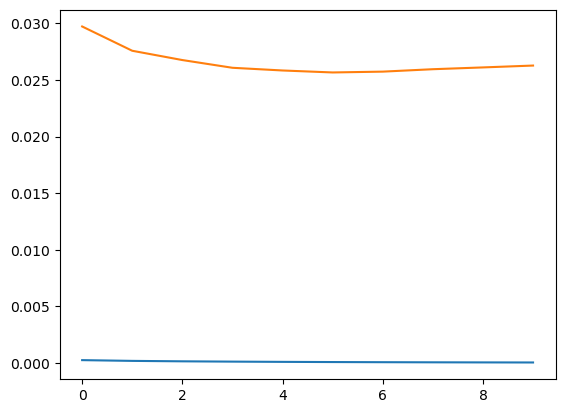

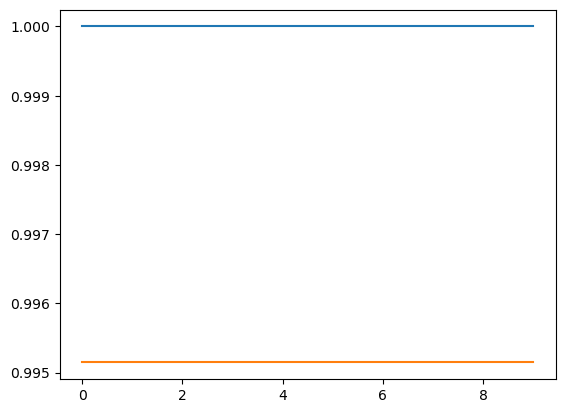

In [71]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(train_loss)
plt.plot(val_loss)
plt.show()
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

In [79]:
model.save(os.path.join("models", "building_recognition_transf_v1.h5"))

In [80]:
class_names

['building', 'not building']

In [76]:
# test sample images:
import os
import numpy as np
import matplotlib.pyplot as plt
SAMPLE_DIR = os.path.join('sample_images', 'building testing')

ds_testing = tf.keras.preprocessing.image_dataset_from_directory(
    SAMPLE_DIR,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=None
)

Found 30 files belonging to 1 classes.


In [77]:
def get_prediction(prediction, _class_names):
    one_hot_array = prediction[0]
    max_confidence = max(one_hot_array)
    if max_confidence < 0.5:
        return 'unsure'
    else:
        return _class_names[one_hot_array.argmax()]

2022-12-04 17:52:17.149283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


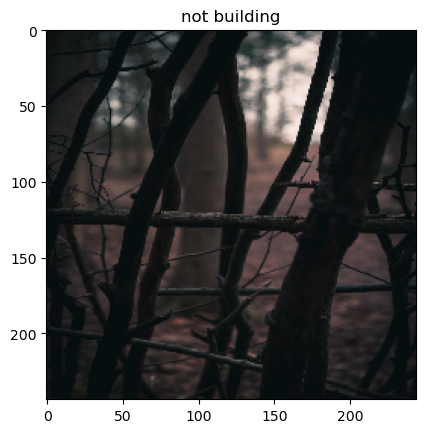

1/1 [==============================] - 0s 25ms/step


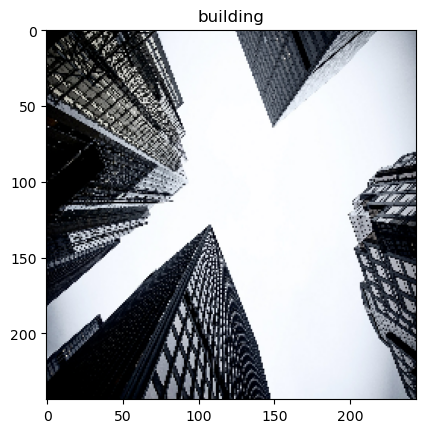

1/1 [==============================] - 0s 95ms/step


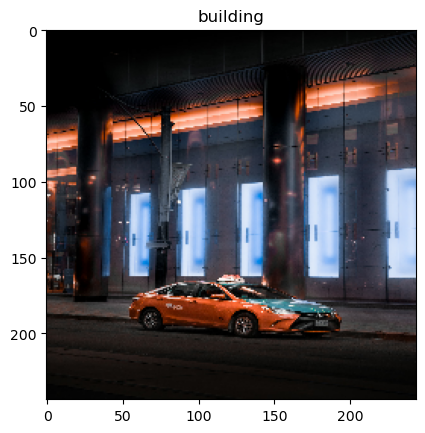

1/1 [==============================] - 0s 19ms/step


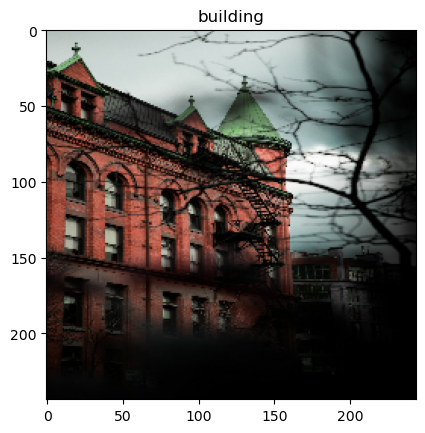

1/1 [==============================] - 0s 22ms/step


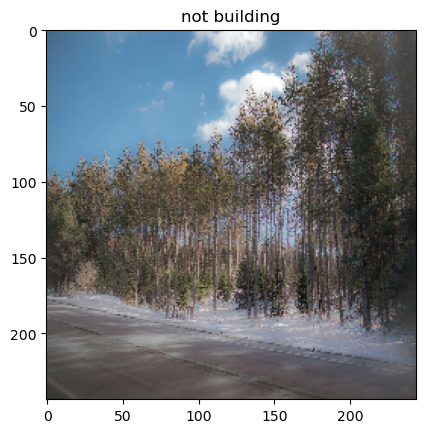

1/1 [==============================] - 0s 19ms/step


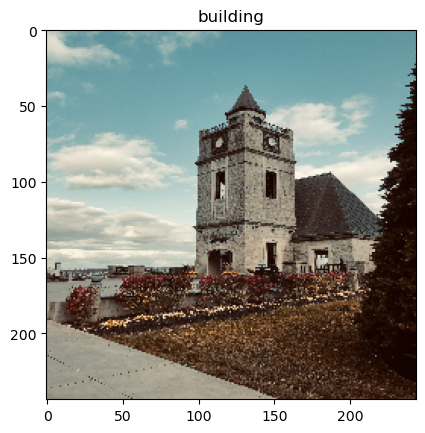

1/1 [==============================] - 0s 20ms/step


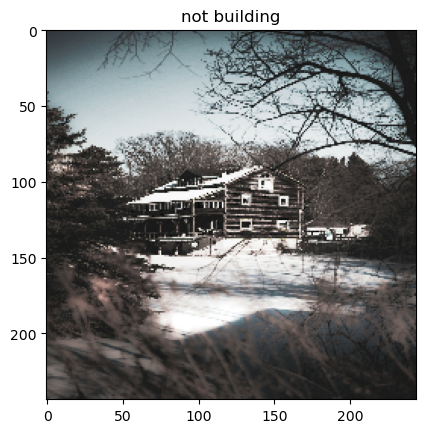

1/1 [==============================] - 0s 20ms/step


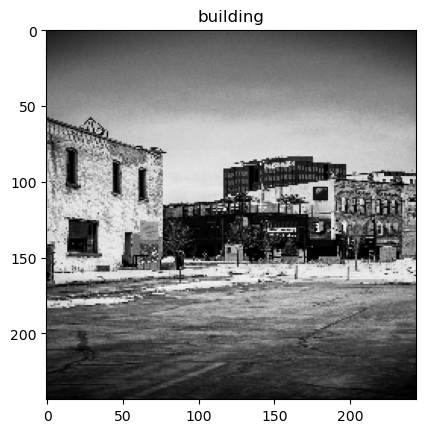

1/1 [==============================] - 0s 19ms/step


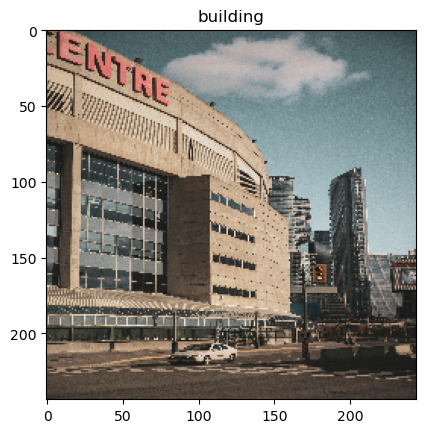

1/1 [==============================] - 0s 20ms/step


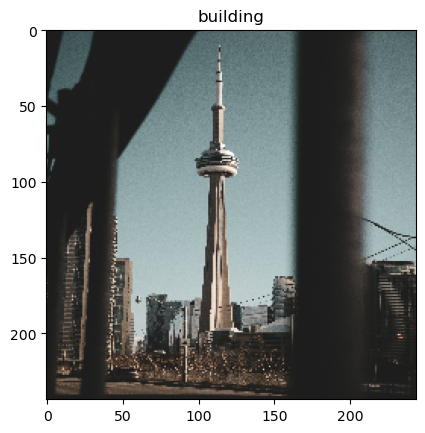

1/1 [==============================] - 0s 21ms/step


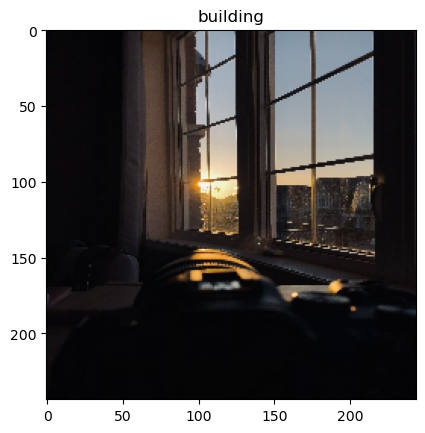

1/1 [==============================] - 0s 22ms/step


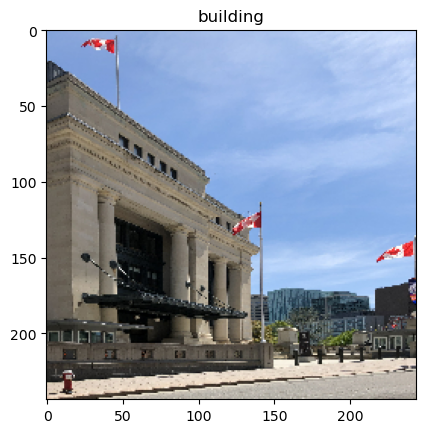

1/1 [==============================] - 0s 21ms/step


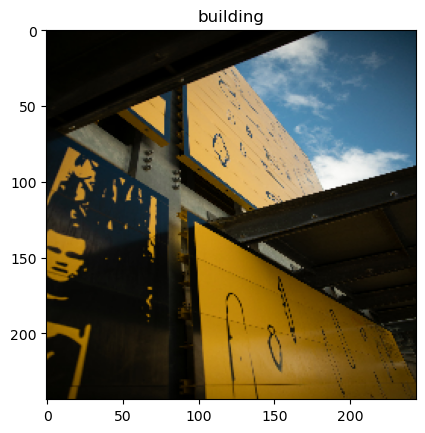

1/1 [==============================] - 0s 22ms/step


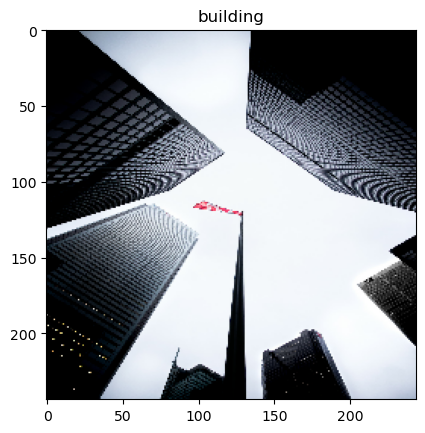

1/1 [==============================] - 0s 22ms/step


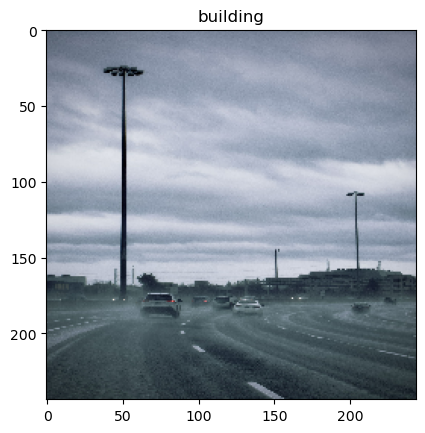

1/1 [==============================] - 0s 21ms/step


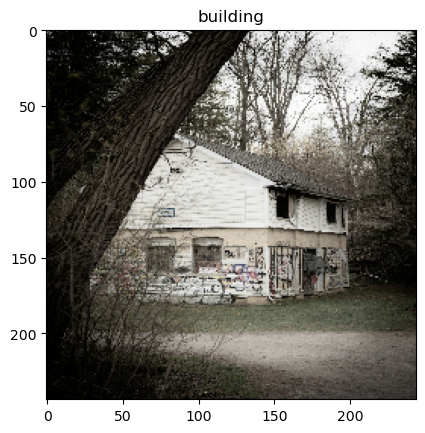

1/1 [==============================] - 0s 21ms/step


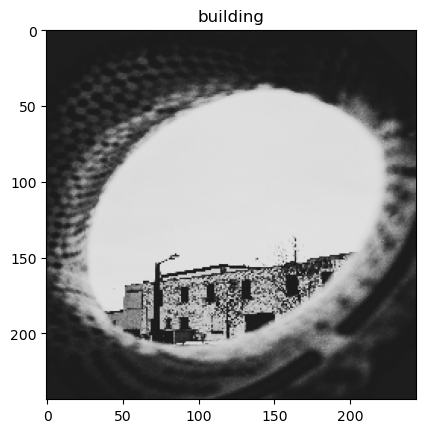

1/1 [==============================] - 0s 21ms/step


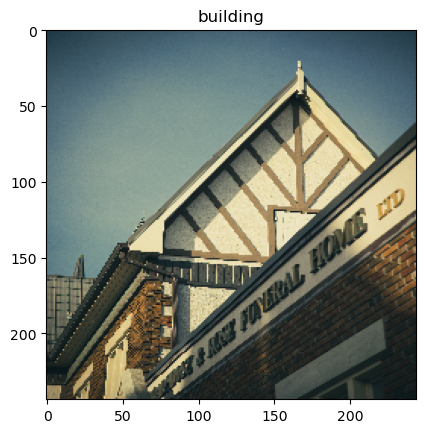

1/1 [==============================] - 0s 19ms/step


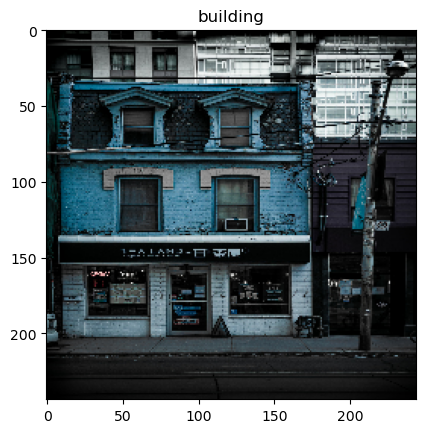

1/1 [==============================] - 0s 20ms/step


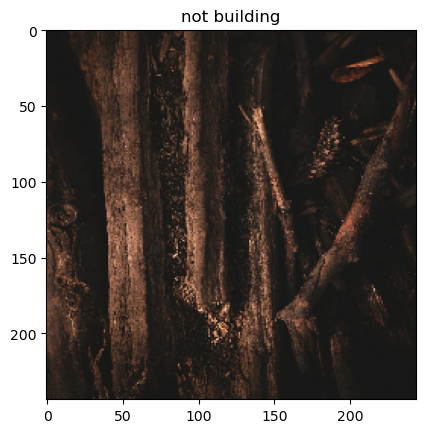

1/1 [==============================] - 0s 21ms/step


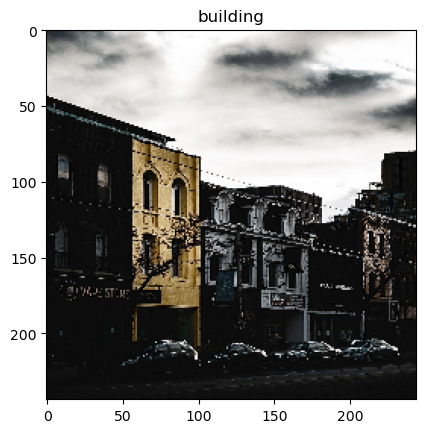

1/1 [==============================] - 0s 20ms/step


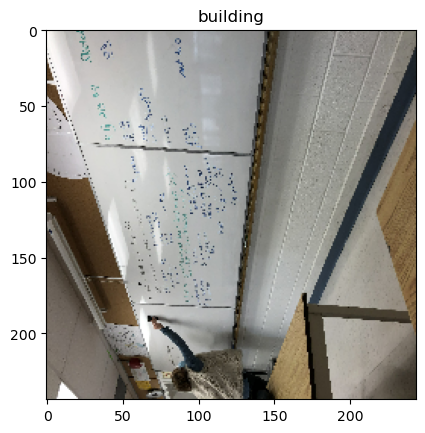

1/1 [==============================] - 0s 21ms/step


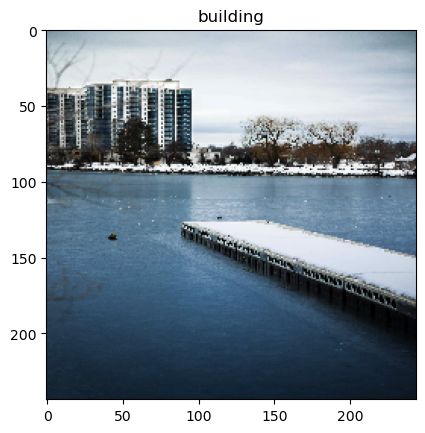

1/1 [==============================] - 0s 19ms/step


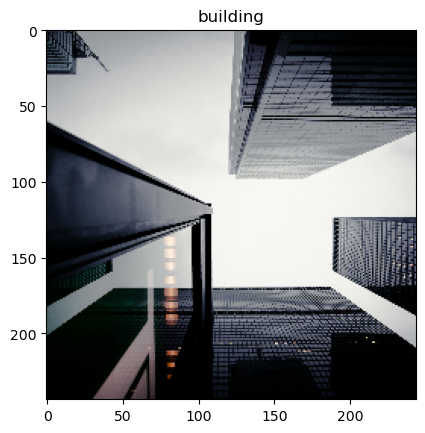

1/1 [==============================] - 0s 21ms/step


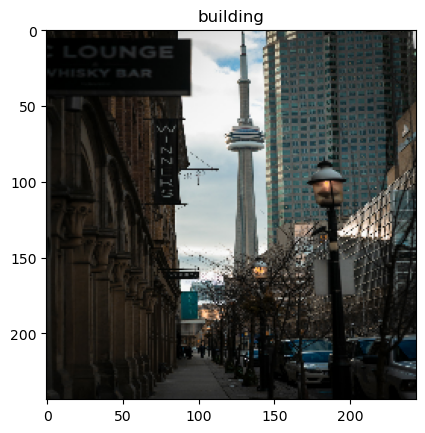

In [78]:
for images in ds_testing:
    for i in range(25):
        try:
            image = images[i]
            plt.imshow(image.numpy().astype("uint8"))
            predictions = model.predict(np.expand_dims(image, axis=0))
            plt.title(get_prediction(predictions, class_names))
            plt.show()
        except Exception as e:
            print(e)